# Introduction

La pratique de l'aviron en milieu naturel, comme sur les fleuves et rivières, dépend fortement des conditions hydrologiques telles que le débit et la hauteur d'eau. Ces paramètres jouent un rôle crucial dans la sécurité des rameurs, la qualité de l'expérience sportive, et l'organisation des entraînements et des compétitions. Toutefois, les variations du débit et de la hauteur d'eau, souvent influencées par les conditions météorologiques (pluies, sécheresses), rendent leur prévision essentielle pour les clubs d'aviron et leurs pratiquants. Ce projet, centré sur la Seine, vise donc à développer un modèle de prédiction fondé sur des données hydrométriques et météorologiques, permettant d'anticiper les conditions optimales pour la pratique de l'aviron ou à l'inverse de détecter ses potentiels dangers. En combinant l'analyse de données historiques, allant du 01/01/23 à aujourd'hui, avec des approches de modélisation, ce travail a pour objectif de fournir un outil fiable et pratique pour faciliter la planification et garantir la sécurité de la pratique sportive.

Ce projet comprend 3 grandes parties : 
- Dans la première partie, nous importons les bases de données utiles
- Dans la deuxième partie, nous étudions et analysons les données recueillies pour préparer le modèle prédictif
- Dans la troisième partie, nous modélisons le problème pour tenter d'y apporter une réponse satisfiasante

In [1]:
# !pip install cartopy
# !pip install geopy

In [2]:
import glob
import os
import requests
import warnings 

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import datetime, timedelta
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

In [3]:
os.chdir("/home/onyxia/work/Projet-de-Python-Leroux-Gisserot") # pour l'emplacement
os.environ["PROJ_LIB"] = "/opt/conda/share/proj" # pour les projections sur carte

# Data loading

Dans cette partie, nous importons de data.gouv.fr :
- des bases de données météo horaire pour chaque département
- une base de données concernant la hauteur d'eau et le débit des cours d'eau
- une base de données permettant de tracer ces cours d'eau sur une carte
- une base de données permettant de localiser les clubs d'aviron

In [4]:
from utils.data_loading import (
    read_csv_from_url, 
    load_department_data,
    load_and_save_all_department_data,
    load_data_from_disk,
    cleaning_and_organizing,
    get_coordinates,
    import_geojson_from_url,
    find_nearest_station,
    add_station_info_to_clubs,
)

---

Téléchargement des bases de données météo horaire, puis concaténation et nettoyage

In [5]:
'''
load_and_save_all_department_data(
    department_ids=["10", "27", "76", "77", "78", "91", "92", "95"], # départements par lesquels passe la Seine
    save_dir="/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-weather-23-24"
)
'''

'\nload_and_save_all_department_data(\n    department_ids=["10", "27", "76", "77", "78", "91", "92", "95"], # départements par lesquels passe la Seine\n    save_dir="/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-weather-23-24"\n)\n'

In [6]:
meteo_horaire = load_data_from_disk(data_dir="/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-weather-23-24")

Loading and concatenating data from disk: 100%|██████████| 8/8 [00:00<00:00, 10.07it/s]


In [7]:
meteo_horaire = cleaning_and_organizing(
                                df=meteo_horaire,
                                columns=["DEPARTMENT_ID", "NOM_USUEL", "AAAAMMJJHH"],
                                date="AAAAMMJJHH"
                            )

Le dataframe meteo_horaire contient les colonnes suivantes :
- DEPARTMENT_ID : le numéro du département où se trouve la station météo
- NUM_POSTE : l'identifiant de la station météo
- NOM_USUEL : le nom de la commune où se trouve la station météo
- LAT et LON : les coordonnées de la station météo
- AAAAMMJJHH : la date exacte, à l'heure près, de la collecte d'information
- RR1 : les précipitations tombées en une heure (en mm)
- T : la température moyenne enregistrée pendant cette heure

On crée ensuite un dataframe qui nous servira à faire des prédictions effectives (données receuillies sur les 30 derniers jours).

In [8]:
date_ajd = pd.to_datetime(datetime.now())
date_debut = date_ajd - timedelta(days=30)
meteo_horaire_pred = meteo_horaire[(meteo_horaire['AAAAMMJJHH'] > date_debut) & (meteo_horaire['AAAAMMJJHH'] <= date_ajd)]

---

Création du dataset clubs d'aviron et récupération de leurs coordonnées GPS

In [9]:
clubs_aviron = pd.read_csv('/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/adresses_clubs.csv', sep=';', header=0)

In [10]:
clubs_aviron[['LAT', 'LON']] = clubs_aviron['Adresse'].apply(get_coordinates)

---

Création du dataset stations hydrométriques

In [11]:
liste_stations_hydro = pd.read_csv('/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/liste-stations.csv', sep=';', header=0)

In [12]:
liste_stations_hydro = liste_stations_hydro.rename(columns={'cdentite': 'NUM_POSTE', 'lbstationhydro': 'NOM_USUEL', 'longitude': 'LON', 'latitude': 'LAT'})
liste_stations_hydro = liste_stations_hydro[~liste_stations_hydro["dtfermeture"].notna()] # Filtration des stations hydrométriques encore en activité
liste_stations_hydro = liste_stations_hydro.drop(['typestation', 'dtmiseservice', 'dtfermeture'], axis=1)

---

Ajout des stations météo et hydro les plus proches de chaque club d'aviron

In [13]:
stations_meteo_clubs = add_station_info_to_clubs(clubs_aviron, meteo_horaire, filter_keyword=None)
stations_meteo_clubs = stations_meteo_clubs.rename(columns={'NUM_POSTE': 'NUM_NWS', 'NOM_USUEL': 'NWS'}) # NWS = Nearest Weather Station

In [14]:
stations_hydro_clubs = add_station_info_to_clubs(clubs_aviron, liste_stations_hydro, filter_keyword='Seine')
stations_hydro_clubs = stations_hydro_clubs.rename(columns={'NUM_POSTE': 'NUM_NHS', 'NOM_USUEL': 'NHS'}) # NHS = Nearest Hydro Station

In [15]:
clubs_hydro_meteo = pd.merge(stations_meteo_clubs, stations_hydro_clubs, on=["Club", "Adresse", "LAT", "LON"], how="inner")

On en tire par là-même la liste des stations hydro dont il faut récupérer les données

In [16]:
station_ids = clubs_hydro_meteo['NUM_NHS'].drop_duplicates().tolist()

___

Création du dataset débit horaire

In [17]:
debit_horaire = load_data_from_disk(data_dir="/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-flow-rate-23-24")

Loading and concatenating data from disk: 100%|██████████| 15/15 [00:00<00:00, 57.83it/s]


In [18]:
debit_horaire = debit_horaire.rename(columns={'Date (TU)': 'AAAAMMJJHH', 'Valeur (en m³/s)': 'debit', 'NUM_POSTE': 'NUM_POSTE_H', 'NOM_USUEL': 'NOM_USUEL_H'})
debit_horaire = debit_horaire.drop(['Statut', 'Qualification', 'Méthode', 'Continuité'], axis=1)
debit_horaire['AAAAMMJJHH'] = pd.to_datetime(debit_horaire['AAAAMMJJHH'], utc=True).dt.tz_localize(None)

---

Importation de la base de données fluviales

In [19]:
rivers = import_geojson_from_url(
                geojson_url="https://www.data.gouv.fr/fr/datasets/r/f354a037-4a4e-4e7e-804b-01278ab228c5",
                geojson_file="/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/rivers.geojson"
            )

# **Data analysis**

In [20]:
from utils.data_analysis import (
    carte_figures,
    trace_graphique,
    trace_graphique_multiple,
)

**1. Représentation graphique des fleuves, des stations météo et hydro, et des clubs d'aviron**

In [21]:
coord_ws = pd.merge(clubs_hydro_meteo, meteo_horaire, left_on='NUM_NWS', right_on='NUM_POSTE', how="inner")
coord_ws = coord_ws[["NUM_NWS", "NWS", "LAT_y", "LON_y"]].drop_duplicates()
coord_ws = coord_ws.rename(columns={'LAT_y': 'LAT', 'LON_y': 'LON'})

In [22]:
coord_hs = pd.merge(clubs_hydro_meteo, liste_stations_hydro, left_on='NUM_NHS', right_on='NUM_POSTE', how="inner")
coord_hs = coord_hs[["NUM_NHS", "NHS", "LAT_y", "LON_y"]].drop_duplicates()
coord_hs = coord_hs.rename(columns={'LAT_y': 'LAT', 'LON_y': 'LON'})

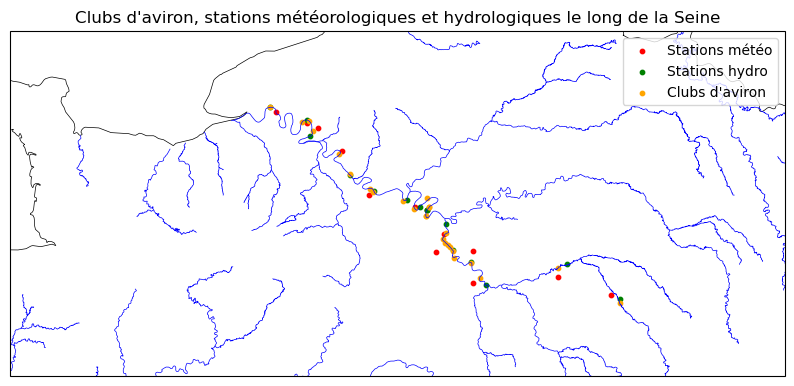

In [23]:
carte_figures(rivers, coord_ws, coord_hs, clubs_aviron)

On choisit à présent un club d'aviron, et indirectement, les stations météorologique et hydrologique les plus proches. Le reste de la partie a pour but de tracer différents graphiques (les précipitations, la température ou encore le débit en fonction du temps) pour tenter de remarquer des tendances ou des corrélations entres les variables.

In [24]:
nom_club = 'Emulation Nautique de Vernon'
nws = clubs_hydro_meteo.loc[clubs_hydro_meteo['Club'] == nom_club, 'NWS'].iloc[0]
nhs = clubs_hydro_meteo.loc[clubs_hydro_meteo['Club'] == nom_club, 'NHS'].iloc[0]
print(f'Les stations météo et hydro les plus proches de {nom_club} sont {nws} et {nhs}')

Les stations météo et hydro les plus proches de Emulation Nautique de Vernon sont LES ANDELYS et La Seine à Vernon - Station débitmétrique (>2006)


---

**2. Graphe des précipitations en fonction du temps**

2. a. <u>Heure par heure</u>

In [25]:
meteo_nws = meteo_horaire[meteo_horaire["NOM_USUEL"] == nws].copy()
meteo_nws = meteo_nws.dropna(subset=['RR1', 'T'])

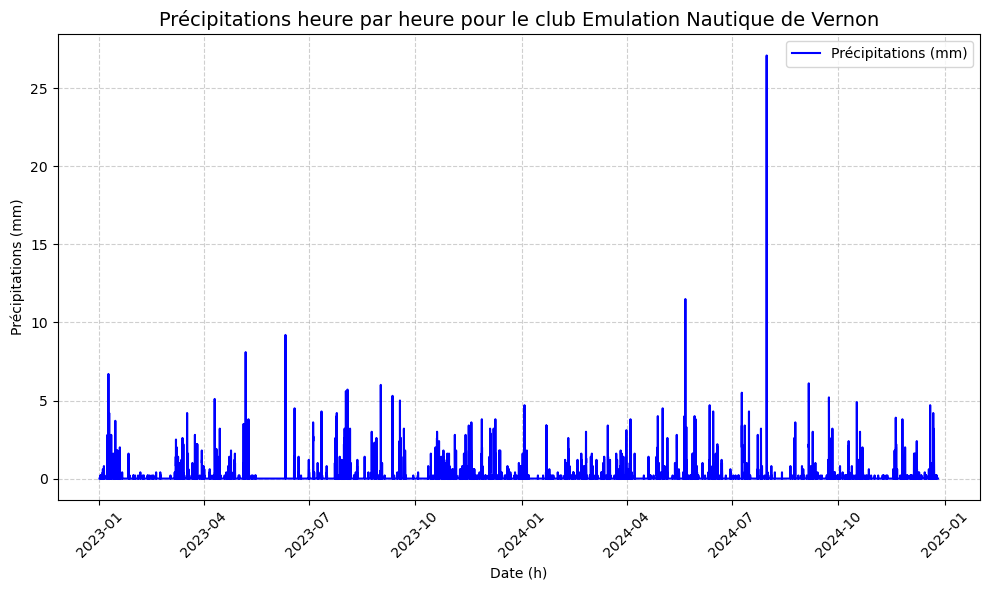

In [26]:
trace_graphique(
    x=meteo_nws["AAAAMMJJHH"],
    y=meteo_nws["RR1"],
    titre=f"Précipitations heure par heure pour le club {nom_club}",
    xlabel="Date (h)",
    ylabel="Précipitations (mm)",
)

Ce graphique détaille les précipitations enregistrées **heure par heure**. Il met en évidence la nature très variable des précipitations, avec de nombreux pics irréguliers.  
- Les pics isolés témoignent de périodes courtes mais **intenses de précipitation**.  
- Entre ces pics, les précipitations sont souvent nulles ou très faibles.  

Cette granularité **horaire**, utile pour analyser la variabilité des précipitations à court terme, rend difficile la lecture des **tendances globales** à cause de l'apparente saturation de l'information.

Pour un modèle de prévision du débit, ces données brutes heure par heure peuvent donc être **trop détaillées** pour être directement exploitées. En effet, les débits d'un cours d'eau dépendent davantage de cumuls sur des périodes plus longues (journées ou semaines) que d'événements ponctuels. Il faut de toute façon étudier l'impact que peut avoir une grosse averse, come observée vers août 2024, sur le débit de la Seine.

2. b. <u>Par semaine</u>

In [27]:
# On crée un dataframe où les précipitations sont sommées par semaine
meteo_nws['hebdo'] = meteo_nws['AAAAMMJJHH'].dt.to_period('W')
precipit_hebdo = meteo_nws.groupby('hebdo', as_index=False)['RR1'].sum()
precipit_hebdo['hebdo'] = precipit_hebdo['hebdo'].dt.to_timestamp(how='start')

# Puis on fait une moyenne glissante sur 3 semaines pour lisser la courbe
precipit_hebdo['moy_gliss'] = precipit_hebdo['RR1'].rolling(window=3, min_periods=1, center=True).mean()

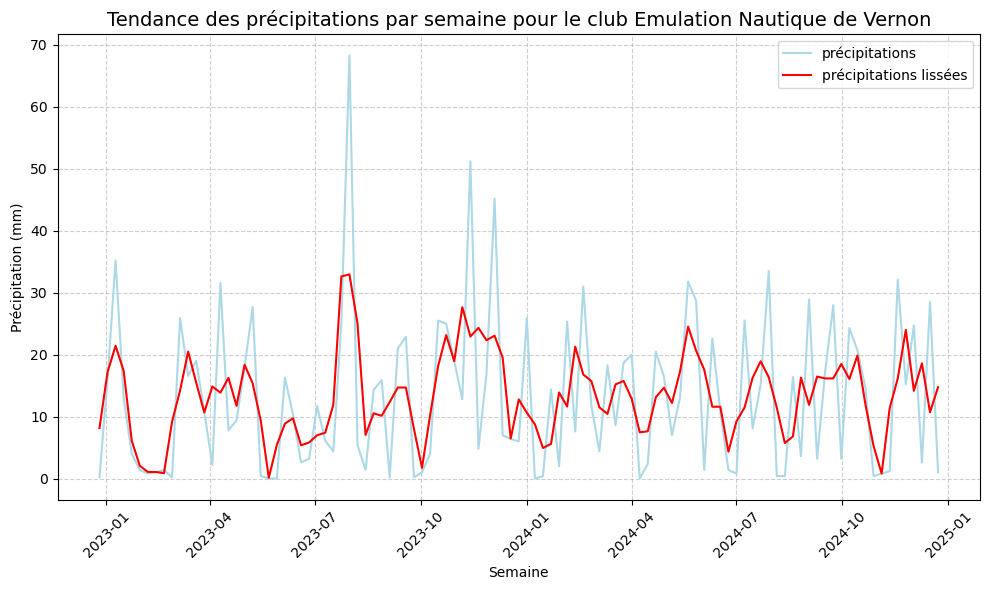

In [28]:
# Préparation des données pour la fonction
y_dico1 = {
    "précipitations": {"y": precipit_hebdo["RR1"], "color": "lightblue", "linestyle": "-"},
    "précipitations lissées": {"y": precipit_hebdo["moy_gliss"], "color": "red", "linestyle": "-"}
}

# Appel de la fonction
trace_graphique_multiple(
    x=precipit_hebdo["hebdo"],
    y_mult=y_dico1,
    titre=f'Tendance des précipitations par semaine pour le club {nom_club}',
    xlabel="Semaine",
    ylabel="Précipitation (mm)",
)

Ce graphique agrège les précipitations à une échelle **hebdomadaire**, ce qui permet de mieux identifier les **tendances globales** dans les précipitations :  
- En bleu clair : la somme hebdomadaire des précipitations montre les fluctuations globales des précipitations au fil du temps.  
- En rouge : la moyenne glissante sur 3 semaines lisse les variations hebdomadaires, révélant les tendances de fond sans être perturbée par des oscillations trop rapides.

Ce lissage est particulièrement utile pour **détecter les périodes humides ou sèches prolongées**, qui influencent directement le débit des cours d'eau. On observe plusieurs tendances significatives sur l'année 2023 et 2024, où des périodes de fortes précipitations suivent des périodes de faibles précipitations.

Les **sommations hebdomadaires** permettent de mieux relier les précipitations aux variations de débit, car elles intègrent une échelle temporelle plus pertinente pour l'évolution du niveau d'eau. La moyenne glissante aide à anticiper les périodes où les cours d'eau risquent d'atteindre des niveaux élevés, en réponse à des cumuls prolongés.

---

Pour **prédire le débit d'un cours d'eau**, il serait pertinent d'utiliser les données hebdomadaires comme **variable explicative principale**, en intégrant les tendances de fond issues de la moyenne glissante pour améliorer les prédictions, sachant que de fortes précipitations sur les dernières heures peuvent rapidement faire varier le niveau d'eau à court terme.

---

**3. Graphe des températures en fonction du temps**

3. a. <u>Heure par heure</u>

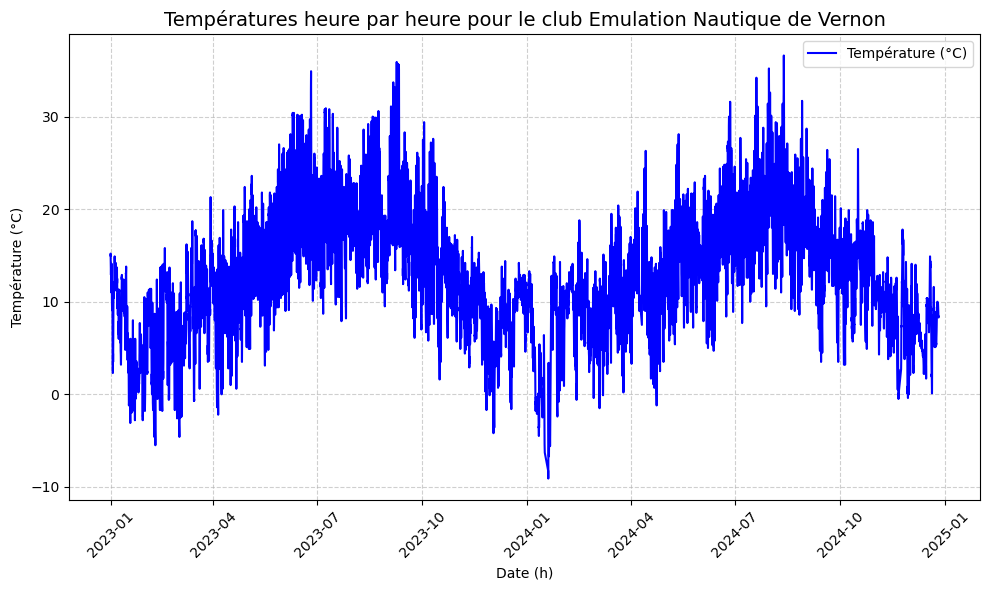

In [29]:
trace_graphique(
    x=meteo_nws["AAAAMMJJHH"],
    y=meteo_nws["T"],
    titre=f"Températures heure par heure pour le club {nom_club}",
    xlabel="Date (h)",
    ylabel="Température (°C)",
)

Ce graphique montre l'évolution de la température en fonction du temps à une résolution horaire. Il met à la fois en évidence les tendances globales de température en fonction des saisons (20-25°C vers juillet-août et autour de 5°C en janvier-février, aussi bien en 2023 qu'en 2024) et leur variabilité journalière.

**Saisonnalité temporelle** : ce type de comportement est crucial pour la prédiction des débits, car les températures influencent l'évaporation, la fonte des neiges, et donc le débit.

**Variabilité horaire** : les fluctuations à court terme de la température sont visibles sous forme de variations rapides autour de la tendance globale. Ces variations peuvent être liées à des événements météorologiques locaux (comme des fronts froids ou chauds) qui affectent aussi les précipitations et, par extension, le débit des cours d'eau.

**Implication pour la prédiction du débit** : les températures, combinées aux précipitations, influencent directement le débit par la fonte des neiges, l'infiltration dans les sols, et l'évaporation. Ces variations saisonnières et horaires de température doivent donc être intégrées comme une variable explicative dans le modèle de prédiction.

3. b. <u>Par semaine</u>

In [30]:
# On reproduit la même méthode que pour les précipitations
temp_hebdo = meteo_nws.groupby('hebdo', as_index=False)['T'].mean()
temp_hebdo['hebdo'] = temp_hebdo['hebdo'].dt.to_timestamp(how='start')
temp_hebdo['moy_gliss'] = temp_hebdo['T'].rolling(window=3, min_periods=1, center=True).mean()

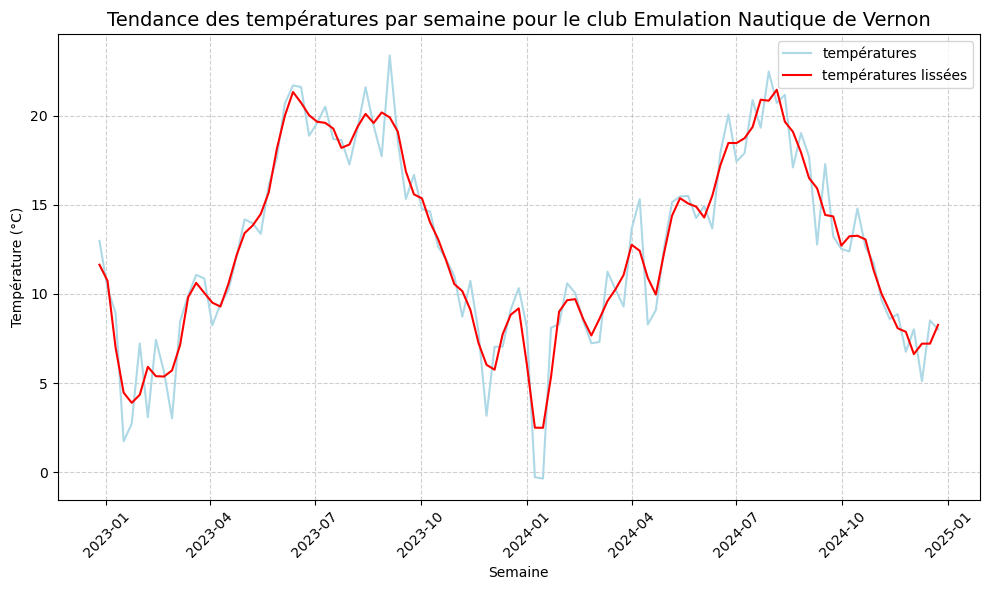

In [31]:
# Préparation des données pour la fonction
y_dico2 = {
    "températures": {"y": temp_hebdo["T"], "color": "lightblue", "linestyle": "-"},
    "températures lissées": {"y": temp_hebdo["moy_gliss"], "color": "red", "linestyle": "-"}
}

# Appel de la fonction
trace_graphique_multiple(
    x=temp_hebdo["hebdo"],
    y_mult=y_dico2,
    titre=f'Tendance des températures par semaine pour le club {nom_club}',
    xlabel="Semaine",
    ylabel="Température (°C)",
)

Ici, on se restreint à la compréhension des tendances globales de températures. Cette restriction ne permet pas de voir de corrélation directe avec les précipitations. Les températures et les précipitations jouent donc probablement leur rôle dans la prédiction du débit des cours d'eau de manière indépendante.

Mais on peut d'ores-et-déjà émettre quelques hypothèses : 
- plus les précipitations sont importantes et plus elles durent longtemps, plus le débit sera élevé, ceteris paribus
- plus la température est élevée et plus la période de chaleur est longue, plus le débit sera faible, ceteris paribus
- plus la température est élevée, plus les précipitations ont un impact positif sur le débit (par ruissellement)

---

**4. Graphe du débit en fonction du temps**

In [32]:
debit_nhs = debit_horaire[debit_horaire["NOM_USUEL_H"] == nhs].copy()
debit_nhs = debit_nhs.dropna(subset='debit')

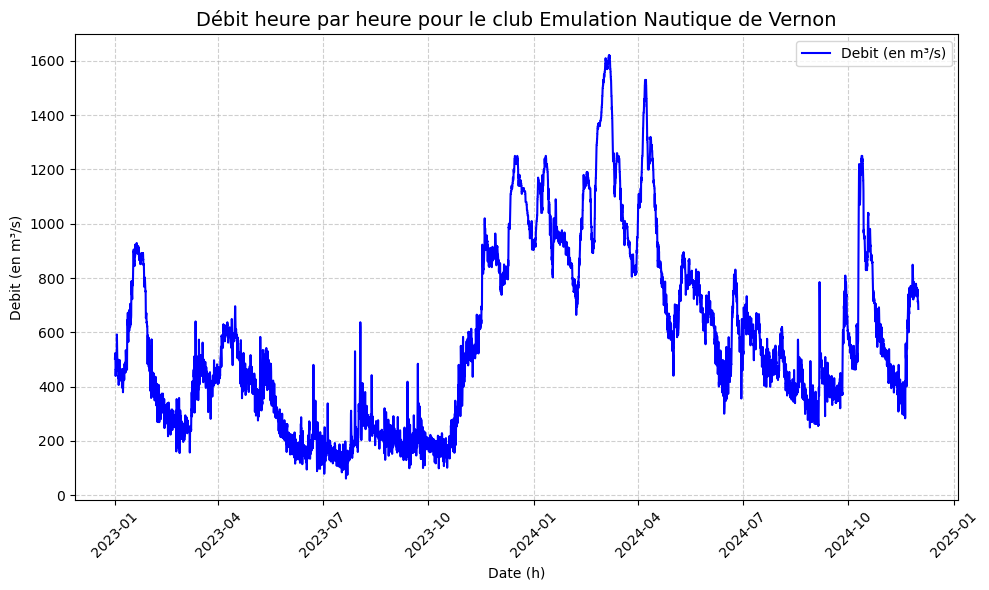

In [33]:
trace_graphique(
    x=debit_nhs["AAAAMMJJHH"],
    y=debit_nhs["debit"],
    titre=f"Débit heure par heure pour le club {nom_club}",
    xlabel="Date (h)",
    ylabel="Debit (en m³/s)",
)

In [34]:
# On reproduit la même méthode que pour les précipitations
debit_nhs['hebdo'] = debit_nhs['AAAAMMJJHH'].dt.to_period('W')
debit_hebdo = debit_nhs.groupby('hebdo', as_index=False)['debit'].mean()
debit_hebdo['hebdo'] = debit_hebdo['hebdo'].dt.to_timestamp(how='start')
debit_hebdo['moy_gliss'] = debit_hebdo['debit'].rolling(window=3, min_periods=1, center=True).mean()

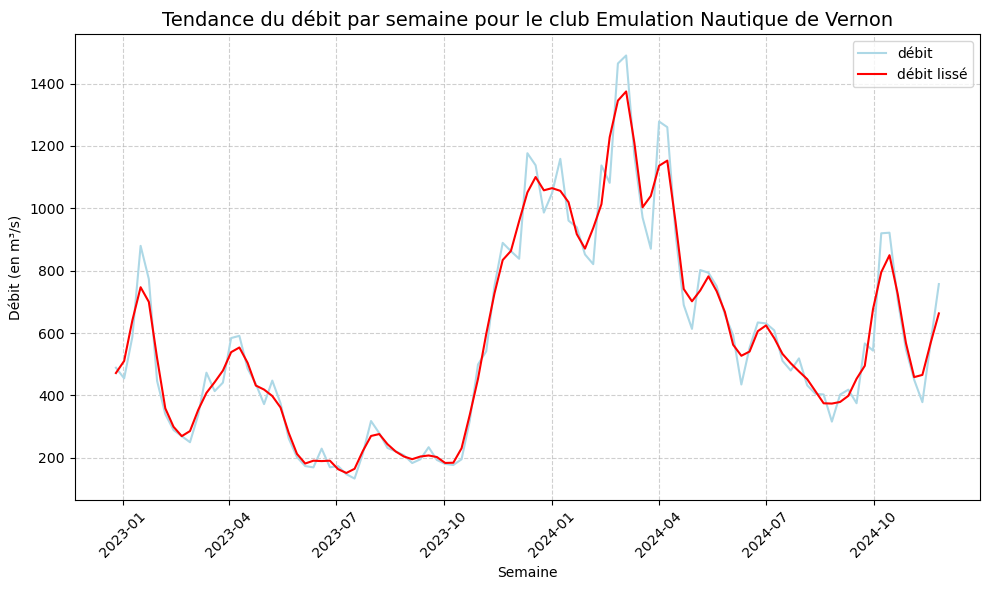

In [35]:
# Préparation des données pour la fonction
y_dico2 = {
    "débit": {"y": debit_hebdo["debit"], "color": "lightblue", "linestyle": "-"},
    "débit lissé": {"y": debit_hebdo["moy_gliss"], "color": "red", "linestyle": "-"}
}

# Appel de la fonction
trace_graphique_multiple(
    x=debit_hebdo["hebdo"],
    y_mult=y_dico2,
    titre=f'Tendance du débit par semaine pour le club {nom_club}',
    xlabel="Semaine",
    ylabel="Débit (en m³/s)",
)

# **Data modeling**

In [36]:
from utils.data_modeling import (
    correlation1,
    correlation2,
    plot_correlations,
    create_features,
)

**1. Constitution du dataframe final**

On crée dorénavant un gros dataframe avec toutes les données qui serviront pour l'entraînement du modèle :
- le club d'aviron
- ses coordonnées GPS
- les station météo et hydro les plus proches
- l'heure de prélèvement des données
- le débit, les précipitations et la température à cette heure

In [37]:
# 1: on joint les données de debit_horaire avec clubs_hydro_meteo sur NUM_NHS
debit_club = debit_horaire.merge(
    clubs_hydro_meteo[['Club', 'LAT', 'LON', 'NUM_NHS', 'NHS']],
    left_on='NUM_POSTE_H',
    right_on='NUM_NHS',
    how='inner'
)

# 2: on joint les données de meteo_horaire avec clubs_hydro_meteo sur NUM_NWS
meteo_club = meteo_horaire.merge(
    clubs_hydro_meteo[['Club', 'LAT', 'LON', 'NUM_NWS', 'NWS']],
    left_on='NUM_POSTE',
    right_on='NUM_NWS',
    how='inner'
)

# 3: on combine les deux DataFrames sur le Club et la colonne temporelle 'AAAAMJJHH'
combined = debit_club.merge(
    meteo_club,
    on=['Club', 'AAAAMMJJHH'],
    suffixes=('_hydro', '_meteo')
)

# 4: on sélectionne les colonnes pertinentes et on copie le dataframe pour éviter les intéractions fâcheuses
result = combined[['Club', 'LAT', 'LON', 'NHS', 'NWS', 'AAAAMMJJHH', 'debit', 'RR1', 'T']].copy()

Au préalable, on doit s'assurer que toutes les valeurs du dataframe sont numériques y compris les dates.

In [38]:
# On convertit les valeurs en nombre
result["debit"] = pd.to_numeric(result["debit"], errors="coerce")
result["LAT"] = pd.to_numeric(result["LAT"], errors="coerce")
result["LON"] = pd.to_numeric(result["LON"], errors="coerce")
result = result.dropna(subset=["debit", "RR1", "T"])

# On supprime les colonnes inutiles pour la prédiction
result = result.drop(columns=["NWS", "NHS"])

# On extrait les caractéristiques temporelles 
result["year"] = result["AAAAMMJJHH"].dt.year
result["month"] = result["AAAAMMJJHH"].dt.month
result["day"] = result["AAAAMMJJHH"].dt.day
result["hour"] = result["AAAAMMJJHH"].dt.hour

# Supprimer la colonne datetime originale si elle n'est plus utile
result = result.drop(columns=["AAAAMMJJHH"])

---

**2. Étude approfondie de corrélation entre les variables**

In [39]:
# Corrélation entre le débit et les précipitations aux heures précédentes
correlation1(result, "RR1", 1, 26, 6)

Corrélation avec RR1 décalé de 1 heure(s) : 0.019033026715354073
Corrélation avec RR1 décalé de 7 heure(s) : 0.019784937178678803
Corrélation avec RR1 décalé de 13 heure(s) : 0.016987177715791068
Corrélation avec RR1 décalé de 19 heure(s) : 0.01613060810606755
Corrélation avec RR1 décalé de 25 heure(s) : 0.01593662695742147


In [40]:
# Corrélation entre le débit et la température aux heures précédentes
correlation1(result, "T", 1, 26, 6)

Corrélation avec T décalé de 1 heure(s) : -0.18827487958922146
Corrélation avec T décalé de 7 heure(s) : -0.1891538283066769
Corrélation avec T décalé de 13 heure(s) : -0.18936186246659187
Corrélation avec T décalé de 19 heure(s) : -0.18887513391015318
Corrélation avec T décalé de 25 heure(s) : -0.188776470806618


In [41]:
# Corrélation entre le débit et le débit aux heures précédentes
correlation1(result, "debit", 1, 26, 6)

Corrélation avec debit décalé de 1 heure(s) : 0.997377771043341
Corrélation avec debit décalé de 7 heure(s) : 0.9843155714986548
Corrélation avec debit décalé de 13 heure(s) : 0.9778341993873807
Corrélation avec debit décalé de 19 heure(s) : 0.975056853377686
Corrélation avec debit décalé de 25 heure(s) : 0.973622681596088


Il vient sans surprise que le débit à l'heure h est très corrélé (coefficient quasiment égal à 1) au débit aux heures h-1, h-2, etc. Inversement, celui-ci semble plutôt indépendant (coefficient faible voire presque nul) des précipitations ou des changements de température récents. Mais disposer du débit de l'heure précédente n'est pas forcément très réaliste dans une optique de prédicition du débit d'un jour sur l'autre par exemple. On peut donc se concentrer sur l'étude de corrélation entre le débit et la moyenne des températures sur les derniers jours, ou entre le débit et la somme des précipitations sur les derniers jours.

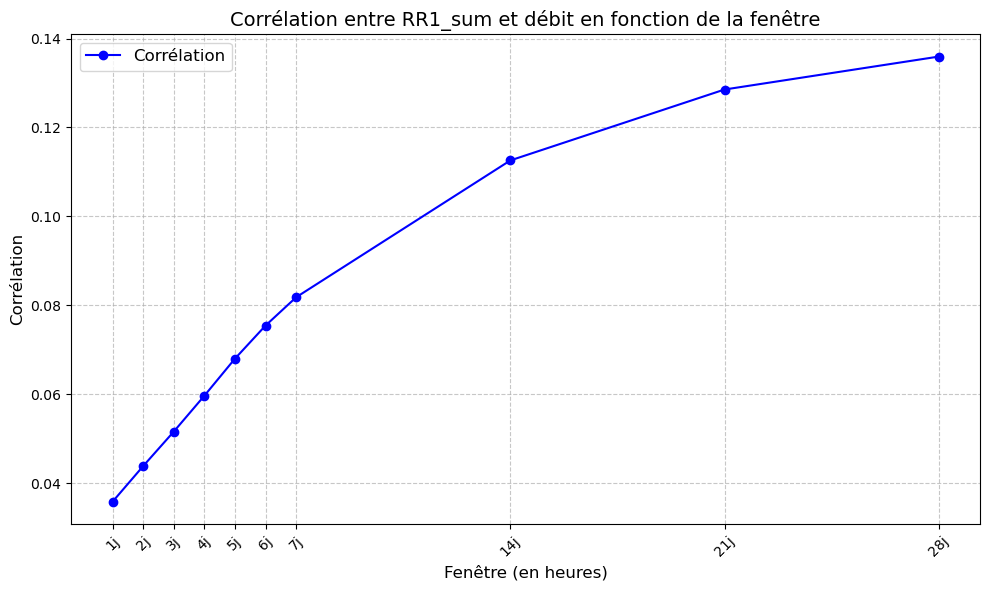

In [42]:
# Corrélation entre le débit et les précipitations sur une période donnée
windows = list(range(24, 6*24+1, 24)) + list(range(7*24, 4*7*24+1, 7*24)) # on définit la fenêtre
correlations_RR1 = correlation2(result, column="RR1", target="debit", periods=windows)
plot_correlations(correlations_RR1, title="Corrélation entre RR1_sum et débit en fonction de la fenêtre")

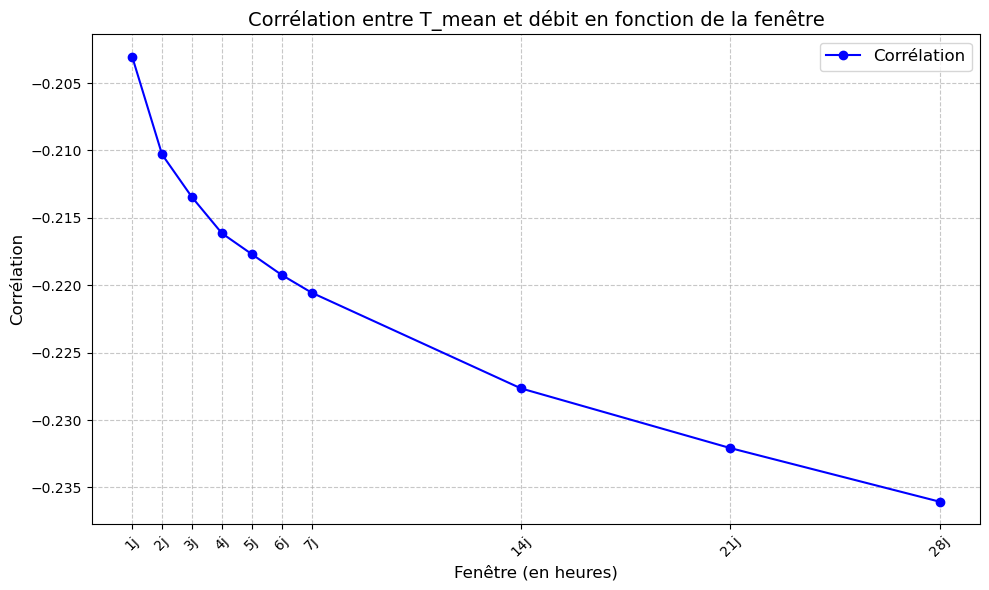

In [43]:
# Corrélation entre le débit et la température sur une période donnée
correlations_T = correlation2(result, column="T", target="debit", periods=windows)
plot_correlations(correlations_T, title="Corrélation entre T_mean et débit en fonction de la fenêtre")

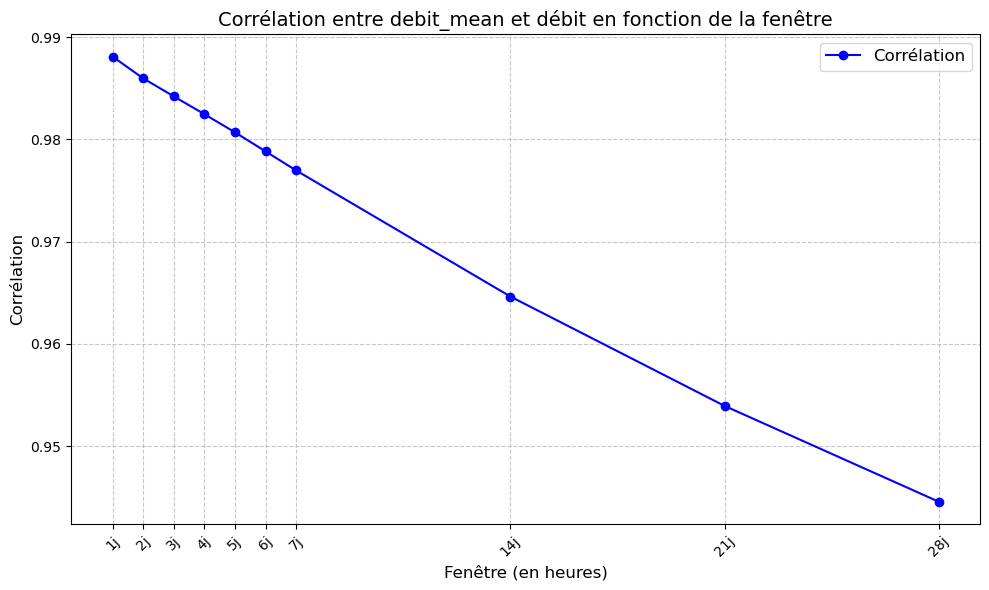

In [44]:
# Corrélation entre le débit et la température sur une période donnée
correlations_debit = correlation2(result, column="debit", target="debit", periods=windows)
plot_correlations(correlations_debit, title="Corrélation entre debit_mean et débit en fonction de la fenêtre")

Sous contrainte de données pour faire des prédictions effectives (30 jours) et par souci de réalisme, nous choisissons pour l'entraînement de retenir les données de débit du jour précédent, la moyenne des températures sur les 28 derniers jours et la somme des précipitations sur les 28 derniers jours également.

---

**3. Modélisation finale**

In [45]:
# Créer les caractéristiques
result = create_features(result).copy()

# Supprimer les lignes avec des valeurs manquantes dues aux décalages
result = result.dropna()

# Définir les caractéristiques et la cible
features = [col for col in result.columns if col not in ["datetime", "Club", "debit"]]
X = result[features]
y = result["debit"]

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraîner un modèle XGBoost
model = XGBRegressor(
    n_estimators=100,  # Nombre d'arbres
    learning_rate=0.1,  # Taux d'apprentissage
    max_depth=5,  # Profondeur maximale des arbres
    subsample=0.8,  # Fraction d'échantillons pour chaque arbre
    colsample_bytree=0.8, # Fraction de colonnes utilisées par arbre
    random_state=42
)

model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

# Évaluer le modèle
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Affichage des résultats
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

RMSE: 17.46
R²: 0.9971
